# Tagup Data Science Exercise

ExampleCo, Inc is gathering several types of data for its fleet of very expensive machines.  These very expensive machines have three operating modes: *normal*, *faulty* and *failed*.   The machines run all the time, and usually they are in normal mode.  However, in the event that the machine enters faulty mode, the company would like to be aware of this as soon as possible.  This way they can take preventative action to avoid entering failed mode and hopefully save themselves lots of money.

They collect four kinds of timeseries data for each machine in their fleet of very expensive machines.  When a machine is operating in *normal* mode the data behaves in a fairly predictable way, but with a moderate amount of noise.  Before a machine fails it will ramp into *faulty* mode, during which the data appears visibly quite different.  Finally, when a machine fails it enters a third, and distinctly different, *failed* mode where all signals are very close to 0.

You can download the data here: [exampleco_data](https://drive.google.com/open?id=1b12u6rzkG1AxB6wLGl7IBVoaoSoZLHNR)

__Your main objective: to develop an automated method to pinpoint the times of fault and failure in this machine__.  Keep in mind that you will be sharing these results with the executives at ExampleCo, so to the best of your ability, try to explain what you are doing, what you've shown, and why you think your predictions are good.


A few notes to help:
1. A good place to start is by addressing the noise due to communication
   errors.
2. Feel free to use any libraries you like, or even other programming
   languages. Your final results should be presented in this notebook, however.
3. There are no constraints on the techniques you bring to bear, we are curious
   to see how you think and what sort of resources you have in your toolbox.
4. Be sure to clearly articulate what you did, why you did it, and how the
   results should be interpreted. In particular you should be aware of the
   limitations of whatever approach or approaches you take.
5. Don't feel compelled to use all the data if you're not sure how. Feel free
   to focus on data from a single unit if that makes it easier to get started.
6. Don't hesitate to reach out to datasciencejobs@tagup.io with any questions!

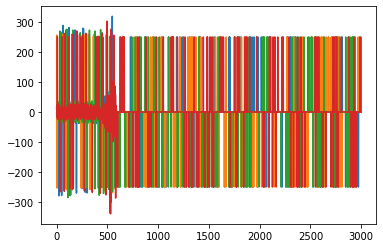

In [1]:
# To help you get started...
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

data = pd.read_csv('data/machine_13.csv',index_col=0)

plt.plot(range(len(data)), data)
plt.show()

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import plotly as px
import pandas as pd
import plotly.graph_objects as go
import plotly.express as pl
from plotly.subplots import make_subplots
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA 
from scipy import ndimage
from scipy import stats
from sklearn.metrics import mean_squared_error


import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from math import sqrt



import keras
import keras.utils
from pyod.models.auto_encoder import AutoEncoder
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler 

Using TensorFlow backend.


### Introduction

#### Anomaly detection is the process of identifying unexpected items or events in the dataset, which differ from the norm. It often applied to unlabeled data. Anomaly detection practiced in fraud, medical (and healthcare), and structural defects.


#### As each of the might function differently, the Anomaly detection solution is machine specific. Based on the 'Normal' state sensor data of a machine, we will detect the anomalies associated with the data. 

#### The algorithm filters out the noise and detects the anomalies which are deviating from the norm. 

#### The Input file for the machine can be selected here. The file columns are named for convenience

In [3]:
machineData = pd.read_csv('data\machine_13.csv')
names = ['dateTime','feature1','feature2','feature3','feature4']
machineData.columns = names
machineData['dateTime'] = pd.to_datetime(machineData['dateTime'])

### Data loading and understanding

In [4]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=machineData['dateTime'], y=machineData['feature1'], name="Feature 1",line_color='deepskyblue'))
fig.add_trace(go.Scatter(x=machineData['dateTime'], y=machineData['feature2'], name="Feature 2",line_color='dimgray'))
fig.add_trace(go.Scatter(x=machineData['dateTime'], y=machineData['feature3'], name="Feature 3",line_color='indianred'))
fig.add_trace(go.Scatter(x=machineData['dateTime'], y=machineData['feature4'], name="Feature 4",line_color='seagreen'))
fig.update_layout(title_text='Machine Sensor Data',xaxis_rangeslider_visible=True)
fig.show()

#### As we can see in the graph the noise is dominating the underlying sensor data. 
#### To better assess the numbers from each of the sensor, we use median filtering, the function cleans out the data imputies.
#### The filtering algorithm will scan the entire data, and recalculate the value of the center extreme values by simply taking the median of all of the values inside the matrix.
#### The cleaned out data then can be separated sensor wise to better assess the undelying time series.

In [5]:
machineDataF = machineData[['feature1', 'feature2','feature3','feature4']]
machineDataCleanN =  ndimage.median_filter(np.array(machineDataF),5)
machineDataClean = pd.DataFrame(machineDataCleanN)
machineDataClean.columns = ['feature1', 'feature2','feature3','feature4']
machineDataClean["dateTime"] = machineData["dateTime"]
machineDataCleanOut = machineDataClean
machineDataClean.index = machineDataClean["dateTime"]

fig = make_subplots(rows=4, cols=1)

fig.add_trace(go.Scatter(x = machineDataClean["dateTime"], y=machineDataClean["feature1"]),row=1, col=1)
fig.add_trace(go.Scatter(x = machineDataClean["dateTime"], y=machineDataClean["feature2"]),row=2, col=1)
fig.add_trace(go.Scatter(x = machineDataClean["dateTime"], y=machineDataClean["feature3"]),row=3, col=1)
fig.add_trace(go.Scatter(x = machineDataClean["dateTime"], y=machineDataClean["feature4"]),row=4, col=1)

fig.update_layout(height=800, width=1000, title_text="Subplots")
fig.show()

#### Observations:

#### The individual plotting of the sensor data shows facinating anomalies. We can see in time period 'July 2019 and June 2019',  
#### the normal state of the machine is observed with values fluctuating between average of 8 and -5 with period of 10 days approximately.   
#### In the 'Faulty' zone the sensor fluctuate drastically for a period of a month. Just before this behaviour the values record somewhat low values, deviating from 
#### the median by 20% - 30% for a period of 20 days.

### Data preprocessing and Model implementation

#### The appoach of the anomaly detection in this case is a ensembled. 

#### To brief about this approach, we will implement models which can understand the behaviour of the data from different perspective. Then we will aggregate the results of each model to detect anomalies. 

#### We willl first try to scale and understand the distribution of the data points. For example, the likelihood of sensor showing value lower than average is low, We use Z score scaling to denote such changes in distrubution, which then we can filter out.

#### The models will learn the interaction between the sensor data in the following ways :
    1. Learning the distribution of the data when the machine is working in 'Normal' mode. How the sensors react differently in the 'faulty' state.
    2. Predicting the behaviour of the sensors in 'Normal' mode and detecting anomaly as soon as they deviate from the normal behaviour 
    
#### The different models we use are as follows : 
####    1. K Means Clustering
####    2. One class Support Vector Machines
####    3. Seasonal Autoregressive Integrated Moving Average (SARIMA) - Combination of Seasonal Autoregressive and Moving Average alogrithm
####    4. LSTM Autoencoder neural networks

#### The ensembled approach gives us the power to tune the sensitivity of anomaly detection. 


#### The data from the 4 sensors is a little diffcult to assess and understand. We will use the 2 
#### Thus we will represent the data in more interpretable format with only 2 data series without losing any of the characteristics of original data. This technique is called as Principal Component Analysis. 
#### We will use this interpretable data of PCA for clustering based and linear models

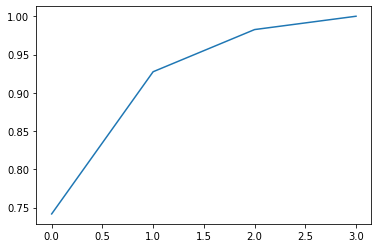

In [6]:
pca = PCA(n_components=4).fit(machineDataCleanN)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

pca1 = PCA(n_components=2)
dropCleanPCA = pca1.fit_transform(machineDataCleanN)
dropCleanPCA = stats.zscore(dropCleanPCA)
machineDataCleanQ = pd.DataFrame(dropCleanPCA)
machineDataCleanQ.index = machineDataCleanOut.index

fig2 = go.Figure()

fig2.add_trace(go.Scatter(x=machineDataCleanQ.index, y=machineDataCleanQ[0], name="Feature 1",line_color='gray'))

fig2.add_trace(go.Scatter(x=machineDataCleanQ.index, y=machineDataCleanQ[1], name="Feature 2",line_color='red'))

#### As we can see, The data is more interpretable with 2 time series or 2 Principal Components. The small graph above shows the amout of data (variance) retained by compressing the data from 4 dimensions to 2. It's at 98%, thus its almost same as the original one 

#### 1. K means - It is a proximity based algorithm where the data points are cluster based on the distance (similarity) between them. The PCA components are passed to this clustering to detect outliers

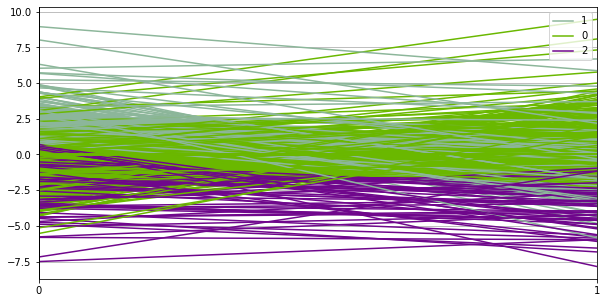

In [7]:
KmachineDataClean = machineDataCleanQ[[0,1]]
kFit = KMeans(n_clusters=3).fit(KmachineDataClean)
predict = kFit.predict(KmachineDataClean)
label = kFit.labels_
fig = plt.figure(figsize=(10,5))
KmachineDataClean['cluster'] = predict
pd.plotting.parallel_coordinates(KmachineDataClean, 'cluster')

#### The graph above is the conventional parrallel coordinate representation of the clustered data. Each of the vertical axis represents time series. We are clustering the data in 3 clusters. Now we will try to filter out the points which lie furthest from their clusters i.e. points which are different from the normal points will be highlighted.

#### The following function gives us the freedom to define the fraction of outliers we wish to filter out. In this case we will be filtering out the most outlying 0.01% points

In [8]:
def Distance(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    
    return distance
fraction = 0.01

machineDataKK = pd.DataFrame()
machineDataKK = KmachineDataClean[[0,1]]
machineDataKK.reset_index(drop=True, inplace=True)
distance = Distance(machineDataKK, kFit)

outliers = int(fraction*len(distance))

cap = distance.nlargest(outliers).min()
machineDataCleanOut['anomalyKNN'] = np.array((distance >= cap).astype(int))
machineDataCleanQ['anomalyKNN'] = np.array((distance >= cap).astype(int))
machineDataCleanQ.index = machineDataCleanOut.index
a = machineDataCleanQ.loc[machineDataCleanQ['anomalyKNN'] == 1, [0,1]] 
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=machineDataCleanOut['dateTime'], y=machineDataCleanQ[0], name="PCA 1",line_color='gray'))
fig1.add_trace(go.Scatter(x=machineDataCleanOut['dateTime'], y=machineDataCleanQ[1], name="PCA 2",line_color='red'))
fig1.add_trace(go.Scatter(x=a.index, y=a[0], mode='markers'))
fig1.add_trace(go.Scatter(x=a.index, y=a[1], mode='markers'))


C:\Python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



#### We can see that the distribution for both PCA is detected as an anomaly at May 28th and onwards. Although the algorithm detects few data points from February and March as an anomaly, it is due to the fraction we have set at 0.01, additionally out ensembled approach will be filtering out the 'False positives'

#### 2. One class SVM 

#### We will now try to understand the outliers by fitting a boundary across the data points we have in the time series. 
#### The algorithm classifies the points as 1 or -1 depending on the side of ellipse they lie on. It can be visualised as a boundary around datapoints in space with some point outside the boundary i.e. outliers. The model will detect such points by understanding which side of the ellipse they lie on.    

In [9]:
machineDataSVMscaled = machineDataCleanQ[[0,1]]

scaledSVM = pd.DataFrame(machineDataSVMscaled)
model = OneClassSVM(nu=0.009, kernel="rbf", gamma=0.0015)
model.fit(scaledSVM)
machineDataCleanOut['anomalySVM'] = np.array(model.predict(scaledSVM))
machineDataSVMscaled['anomalySVM'] = np.array(model.predict(scaledSVM))
machineDataSVMscaled.index = machineDataCleanOut.index
a = machineDataSVMscaled.loc[machineDataSVMscaled['anomalySVM'] == -1, [0,1]] #anomaly

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=machineDataSVMscaled.index, y=machineDataSVMscaled[0], name="PCA 1",line_color='gray'))
fig2.add_trace(go.Scatter(x=machineDataSVMscaled.index, y=machineDataSVMscaled[1], name="PCA 2",line_color='red'))
fig2.add_trace(go.Scatter(x=a.index, y=a[0], mode='markers'))
fig2.add_trace(go.Scatter(x=a.index, y=a[1], mode='markers'))
fig2.show()

#### Similar to Kmeans, the SVM model also detect the anomalies, i.e. sudden spike in the values around June and Early July. The SVM is designed more robust than K means. The SVM can detect the end of 'Faulty' state if machine more efficiently than the k means algorithm. This miss match between the algorithm will help us to tune the entire solution in more flexible way 

#### 3. SARIMAX

#### k mean and SVM depend on the distance between the points and distances between them. This approach only work as the outlier filtering method but they do not learn the progressive and seasonality of the time series.

#### Seasonal Autoregressive Integrated Moving Average or SARIMA in short, learns the Seasonality, Trend and Moving Average of the sensor data

#### The parameters used are specifically tuned to closely fit the 4 sensor data. Here we are considering the original sensor data instead of the PCA data. 

C:\Python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(3000, 4) (3000, 4)


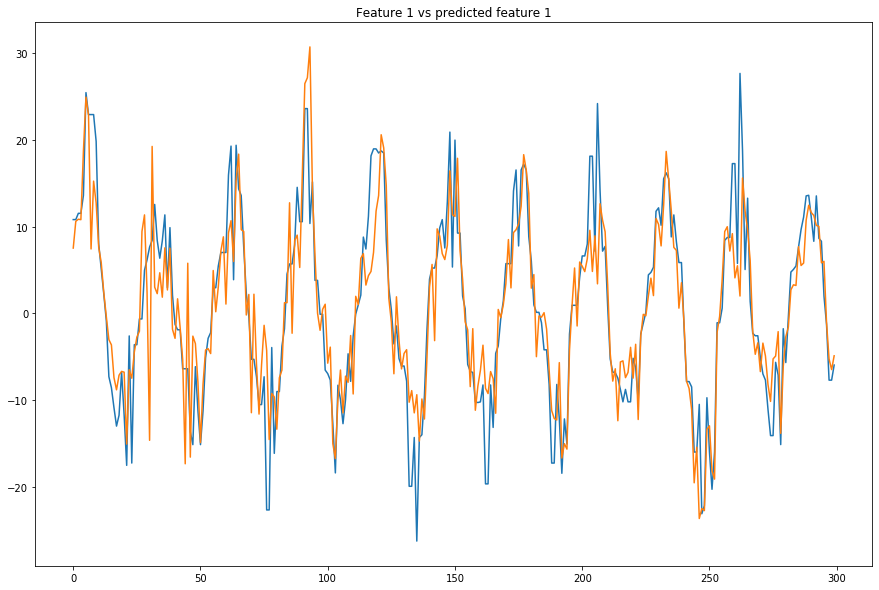

In [10]:
machineDataSari = machineDataClean[['feature1','feature2','feature3','feature4']]

z = len(machineDataClean[['feature1']])
train_s = int(z * 0.10)
test_s = int(z)-train_s
train, test = machineDataSari.iloc[0:train_s], machineDataSari.iloc[0:z]
train = np.array(train)
test = np.array(test)

def Sari(history):
    my_order = (1, 1, 4)
    my_seasonal_order = (1, 1, 1, 24)

    model = sm.tsa.SARIMAX(history, order=my_order, seasonal_order=my_seasonal_order,enforce_stationarity=False,enforce_invertibility=False)
    model = model.fit(disp=0)
    return pd.Series(model.predict(start=1,end=train_s)), pd.Series(model.predict(start=1,end=z))

predictionTrain = pd.DataFrame()
predictionTest = pd.DataFrame()

history1 = [x for x in train[:,0]]
history2 = [x for x in train[:,1]]
history3 = [x for x in train[:,2]]
history4 = [x for x in train[:,3]]

predictionTrain['Predicted1'],predictionTest['Predicted1'] = Sari(history1)[0],Sari(history1)[1] 
predictionTrain['Predicted2'],predictionTest['Predicted2'] = Sari(history2)[0],Sari(history2)[1]
predictionTrain['Predicted3'],predictionTest['Predicted3'] = Sari(history3)[0],Sari(history3)[1]
predictionTrain['Predicted4'],predictionTest['Predicted4'] = Sari(history4)[0],Sari(history4)[1]

NpredictionTest = np.array(predictionTest)
Ntest = np.array(test)

print(NpredictionTest.shape, Ntest.shape)

predictionTest['error'] = (np.square(test - predictionTest)).mean(axis=1)

mse = np.sum((np.square(train - predictionTrain)).mean(axis=1))/train.shape[0]

haze = 1.5
predictionTest['limit'] = mse*haze
predictionTest['anomaly'] = predictionTest['error'] > predictionTest['limit']

machineDataCleanOut['anomalySARI'] = np.array((predictionTest['anomaly']).astype(int))
predictionTest.to_excel('SARIMAX.xlsx')

plt.figure(figsize=(15,10))
plt.plot(train[:,1], label='Training')
plt.plot(predictionTrain['Predicted1'], label='Test')
plt.title("Feature 1 vs predicted feature 1")
plt.show()


#### Given in the graph of feature 1, we can see the SARIMA closely predicts and resembles the actual 'Normal' sensor data.
#### Based on the errors made in the approximation of training data i.e. normal data, we calculate the boundary error. If any predicted observation in the test data i.e. entire dataset is higher than boundary, we highlight that point as an anomaly.   



#### 4. LSTM Autoencoder Neural Networks


#### The fourth model on the enesmbled approach is the Autoencoder Neural Networks.

#### The approach to detect the outliers is as follows : The Autoencoders take an input, break it down in a compressed version. The compressed version of the data is then used to reconstruct the original input. The fundamental approach under the hood is to use the neural network’s hidden layers to learn the characteristics of the data while compressing it. 
#### Thus when the reconstruction occurs, the outliers with lack of original properties will get filtered out.


#### We train the model on the 'Normal' sensor data. This way, the neural network learn the patterns in the 'Normal' data. Then we calculate the loss endured by each datapoint in the reconstruction of the original data. 

#### LSTM : It is a very important component in the reconstruction of the original dataset capable of learning order dependence in sequence prediction problems. LSTM makes decision by considering the current input, previous output and previous memory. And it generates a new output and alters its memory.

#### If a data point is likely to contribute more in the original data, it will have a low loss associated to it. The data points that are very close to the original datase, tend to suffer low loss in the reconstruction. We can set a boundary of the loss above which the points will be filtered out as an anomaly.   

In [11]:
k = machineDataClean[['feature1','feature2','feature3','feature4']]

train_size = int(len(k) * 0.40)
test_size = len(k) - train_size
trainNN, testNN = k.iloc[0:train_size], k.iloc[train_size:len(k)]
scale = MinMaxScaler()

X_trainNN = np.array(trainNN[['feature1','feature2','feature3','feature4']]) 
X_testNN = np.array(testNN[['feature1','feature2','feature3','feature4']])
X_trainNN = stats.zscore(X_trainNN)
X_testNN = stats.zscore(X_testNN)

X_trainNN = X_trainNN.reshape(X_trainNN.shape[0],1,X_trainNN.shape[1])
X_testNN = X_testNN.reshape(X_testNN.shape[0],1,X_testNN.shape[1])

def NN(X):
    inp = Input(shape=(X.shape[1],X.shape[2]))
    LL1 = LSTM(16,activation='relu',return_sequences=True,kernel_regularizer=regularizers.l2(0.00))(inp)
    LL2 = LSTM(4,activation='relu',return_sequences=False)(LL1)
    LL3 = RepeatVector(X.shape[1])(LL2)
    LL4 = LSTM(4,activation='relu',return_sequences=True)(LL3)
    LL5 = LSTM(16,activation='relu',return_sequences=True)(LL4)
    out = TimeDistributed(Dense(X.shape[2]))(LL5)
    model = Model(inputs=inp, outputs = out)
    
    return model

model = NN(X_trainNN)
model.compile(optimizer='adam',loss='mae')
model.summary()

n_epoch = 100
batch = 20
hist = model.fit(X_trainNN,X_trainNN,epochs=n_epoch,batch_size=batch,validation_split=0.05).history



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 4)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 4)              68  

W0331 19:51:35.941668  8348 deprecation_wrapper.py:119] From C:\Python37\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 1140 samples, validate on 60 samples
Epoch 1/100
1140/1140 [==============================] - 1s 1ms/step - loss: 0.5449 - val_loss: 4.1600e-04
Epoch 2/100
1140/1140 [==============================] - 0s 150us/step - loss: 0.5416 - val_loss: 6.2417e-04
Epoch 3/100
1140/1140 [==============================] - 0s 174us/step - loss: 0.5345 - val_loss: 6.7481e-04
Epoch 4/100
1140/1140 [==============================] - 0s 201us/step - loss: 0.4729 - val_loss: 4.2745e-04
Epoch 5/100
1140/1140 [==============================] - 0s 202us/step - loss: 0.4260 - val_loss: 4.7844e-04
Epoch 6/100
1140/1140 [==============================] - 0s 176us/step - loss: 0.4116 - val_loss: 8.6758e-04
Epoch 7/100
1140/1140 [==============================] - 0s 171us/step - loss: 0.4024 - val_loss: 0.0015
Epoch 8/100
1140/1140 [==============================] - 0s 160us/step - loss: 0.3957 - val_loss: 5.9533e-04
Epoch 9/100
1140/1140 [==============================] - 0s 155us/step - loss: 0.3882 - 

1140/1140 [==============================] - 0s 161us/step - loss: 0.1370 - val_loss: 0.0044
Epoch 78/100
1140/1140 [==============================] - 0s 162us/step - loss: 0.1351 - val_loss: 0.0072
Epoch 79/100
1140/1140 [==============================] - 0s 167us/step - loss: 0.1348 - val_loss: 0.0025
Epoch 80/100
1140/1140 [==============================] - 0s 175us/step - loss: 0.1346 - val_loss: 0.0029
Epoch 81/100
1140/1140 [==============================] - 0s 165us/step - loss: 0.1326 - val_loss: 0.0088
Epoch 82/100
1140/1140 [==============================] - 0s 158us/step - loss: 0.1336 - val_loss: 0.0046
Epoch 83/100
1140/1140 [==============================] - 0s 158us/step - loss: 0.1317 - val_loss: 0.0025
Epoch 84/100
1140/1140 [==============================] - 0s 158us/step - loss: 0.1304 - val_loss: 0.0039
Epoch 85/100
1140/1140 [==============================] - 0s 159us/step - loss: 0.1311 - val_loss: 0.0012
Epoch 86/100
1140/1140 [==============================] - 0

(0.0, 0.6)

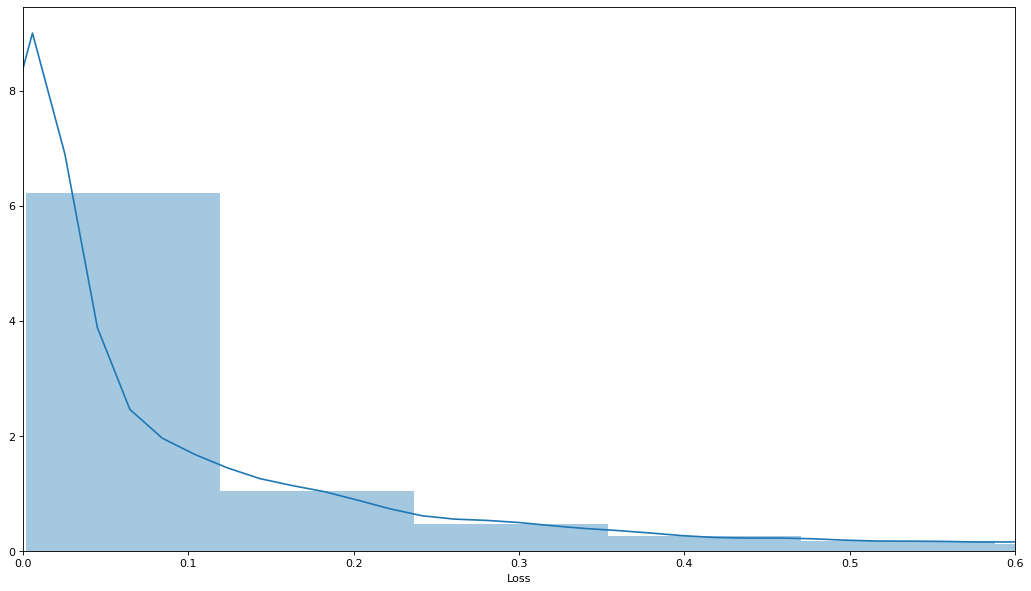

In [12]:
import seaborn as sns 
x_pred = model.predict(X_trainNN)
x_pred = x_pred.reshape(x_pred.shape[0],x_pred.shape[2])
x_pred = pd.DataFrame(x_pred,columns=['feature1','feature2','feature3','feature4'])
x_pred.index = trainNN.index

score = pd.DataFrame(index=trainNN.index)
XtrainNN = X_trainNN.reshape(X_trainNN.shape[0],X_trainNN.shape[2])
score['Loss'] = np.mean(np.abs(x_pred-XtrainNN),axis=1)
plt.figure(figsize=(16,9),dpi=80)
sns.distplot(score['Loss'],bins=20,kde=True)
plt.xlim([0.00,0.60])

#### As we can see, most of the data is represented with loss of less than 0.05%. These points were the 'Normal' state sensor data points getting reconstructed correctly by the neural network. As the loss increases, we can see that neural network finds it challenging to correctly reconstruct the points. This is because of the differences in the distribution of 'Normal' state data and 'Faulty' state data.  

In [12]:
score['limit'] = 0.55
score['anomaly'] = score['Loss'] > score['limit']
score.head()


Loss  limit  anomaly
dateTime                                               
2019-01-01 00:00:00.000000000  0.080937   0.55    False
2019-01-01 08:00:09.603201067  0.455200   0.55    False
2019-01-01 16:00:19.206402134  0.265146   0.55    False
2019-01-02 00:00:28.809603201  0.087900   0.55    False
2019-01-02 08:00:38.412804268  0.309799   0.55    False

#### We can individually test the loss at each datapoint and predict if the point is a potential anomaly. 

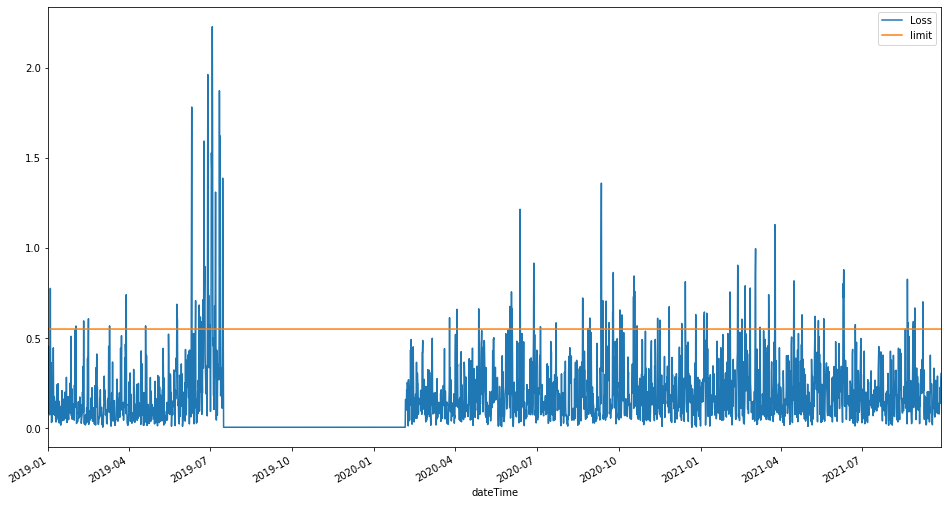

In [13]:
x_pred1 = model.predict(X_testNN)
x_pred1 = x_pred1.reshape(x_pred1.shape[0],x_pred1.shape[2])
x_pred1 = pd.DataFrame(x_pred1,columns=['feature1','feature2','feature3','feature4'])
x_pred1.index = testNN.index

scored_t = pd.DataFrame(index=testNN.index)
XtestNN = X_testNN.reshape(X_testNN.shape[0],X_testNN.shape[2])
scored_t['Loss'] = np.mean(np.abs(x_pred1-XtestNN),axis=1)
scored_t['limit'] = 0.55
scored_t['anomaly'] = scored_t['Loss'] > scored_t['limit']
scoreF = pd.concat([score,scored_t])
scoreF.plot(figsize=(16,9))
machineDataCleanOut['anomalyNN'] = scoreF['anomaly']

#### To better visualize the relation between the loss and the limit, we can see for points lacking the original properties show high loss. The loss limit filters out the abnormal entries in the sensor data. 
#### The Neural networks works as a safety net in our case. The tuning of neural networks is set as sensitive to the sensor data. Additionally, note that for loss for the months from february 2020 is not significant as it is calculated when all sensors are at 0.


### Ensembled predictions

#### The approach for ensembling the models gives the trade off between sensitivity and precision of the predictions. 
#### we have classified anomalies as per alert priorities 'Low' and 'High'. 
#### Based on the anomaly output (True / False) from the models at each data point we filter out the anomalies as 'Low' and 'High' risk

#### 1. Low Risk - If any 2 of the models detect a point to be an anomaly, we then classify the point to be 'Low' risk anomaly
#### 2. High Risk - If any 3 of the models detect a point to be an anomaly, we then classify the point to be 'High' risk anomaly


### Observation -

#### The High risk anomaly points detect the starting point of the 'Faulty' state in the machine.
#### The ensembled approach gives the extra flexibility and tuning for the solution
####  Data from all of the sensors is equally weighted by each of the model. 

### Limitations

#### 1.	Hyperparameter tuning and train test split for the data is machine specific. It is assumed that each machine has a different behavior under stress. 
#### 2.	Performance of the solution depends on the amount of training data. 
#### 3. The approach assumes that Sensitivity/recall of the task is important. The false positive rate is at 3-5%  



In [14]:


machineDataCleanOut['anomalyHigh'] = np.where(((machineDataCleanOut['anomalyNN'] == True)&(machineDataCleanOut['anomalyKNN'] == 1)&(machineDataCleanOut['anomalySVM'] == -1))|
                                        ((machineDataCleanOut['anomalyNN'] == True)&(machineDataCleanOut['anomalySARI'] == 1)&(machineDataCleanOut['anomalySVM'] == -1))|
                                        ((machineDataCleanOut['anomalyNN'] == True)&(machineDataCleanOut['anomalySARI'] == 1)&(machineDataCleanOut['anomalyKNN'] == 1))|
                                        ((machineDataCleanOut['anomalyKNN'] == 1)&(machineDataCleanOut['anomalySARI'] == 1)&(machineDataCleanOut['anomalySVM'] == -1)), 1, 0)

machineDataCleanOut['anomalyLow'] = np.where(((machineDataCleanOut['anomalyNN'] == True)&(machineDataCleanOut['anomalyKNN'] == 1))|
                                             ((machineDataCleanOut['anomalyNN'] == True)&(machineDataCleanOut['anomalySARI'] == 1))|
                                             ((machineDataCleanOut['anomalyNN'] == True)&(machineDataCleanOut['anomalySVM'] == -1))|
                                             ((machineDataCleanOut['anomalyKNN'] == 1)&(machineDataCleanOut['anomalySARI'] == 1))|
                                             ((machineDataCleanOut['anomalyKNN'] == 1)&(machineDataCleanOut['anomalySVM'] == -1))|
                                             ((machineDataCleanOut['anomalySARI'] == 1)&(machineDataCleanOut['anomalySVM'] == -1)), 1, 0)

machineDataCleanOut.to_excel('output.xlsx')

###### The Generated output can be seen as a excel file. Please note 'Xlsxwriter' is needed to export the file

### This concludes the Anomaly Detection Solution
